# Assignment 2

Author: Philip Tanofsky

Date: September 19, 2020

In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

# from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

py.init_notebook_mode()

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [2]:
# Code to read in v17, column names have been updated (without upper case letters) for v18

# bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv')
# bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv')
# mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv')
# qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv')
# si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv')

# ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

ny = pd.read_csv('nyc_pluto_20v5_csv/pluto.csv')


# Getting rid of some outliers
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'] != 0)]

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (19,20,22,24,64) have mixed types.Specify dtype option on import or set low_memory=False.



I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [3]:


# wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
# nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
# ny['xcoord'] = 0.3048*ny['xcoord']
# ny['ycoord'] = 0.3048*ny['ycoord']
# ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['xcoord'].values, ny['ycoord'].values)

# ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/).

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [4]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt').count()['bbl'].index,
    y = ny.groupby('yearbuilt').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.FigureWidget(data = [trace], layout = layout)

fig

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': '1dbfaafa-d662-4d51-be6a-a4080c967e28',
 …

Something looks off... You're going to have to deal with this imperfect data to answer this first question. 

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

---

Hello all, here are some pandas tips to help you guys through this homework:

[Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

[Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).

[Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.

[Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

---

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

In [5]:
# Simple data exploration
# Applying head just to see the first 5 rows
ny.head()

borough  block  lot     cd  ct2010  cb2010  schooldist  council  zipcode  \
17       BK   8366  222  318.0  696.02  2002.0        22.0     46.0  11234.0   
58       BK   2571   28  301.0  561.00  1005.0        14.0     33.0  11222.0   
79       BK   3197    8  304.0  429.00  1002.0        32.0     34.0  11237.0   
110      QN     52    7  402.0    7.00  1000.0        30.0     26.0  11101.0   
126      BK   6714   55  314.0  534.00  3000.0        21.0     44.0  11230.0   

    firecomp  ...        appbbl     appdate  plutomapid  firm07_flag  \
17      E323  ...  3.083660e+09  04/26/2019           1          NaN   
58      L106  ...  3.025710e+09  05/09/2019           1          NaN   
79      E218  ...           NaN         NaN           1          NaN   
110     L115  ...           NaN         NaN           1          NaN   
126     L156  ...           NaN         NaN           1          NaN   

     pfirm15_flag version dcpedited   latitude  longitude notes  
17            NaN    20v5       NaN  40.621954 -73.912938   NaN  
58            NaN    20v5       NaN  40.727214 -73.957625   NaN  
79            NaN    20v5       NaN  40.701450 -73.926539   NaN  
110           NaN    20v5       NaN  40.747702 -73.948207   NaN  
126           NaN    20v5       NaN  40.622939 -73.963523   NaN  

[5 rows x 90 columns]

In [6]:
# Curious what the max floor count is. Interesting it's 104, as I thought the initial WTC buildings were 110
ny['numfloors'].max()

104.0

### Bin the floor count by 10
- Create a series to define the bins as 1-9, 10-19, and so on. Also, label the bins appropriately.
- Create a new column with the proper bin category for the floor count.
- Output the counts by bin to confirm accuracy of data.

#### Bin greater than 50
After initially applying a bin for each 10 floors, I realized the final chart was not displaying some of the bins because after applying the log to the count of one, the result was zero. In these instances, these very tall buildings were not getting included in the chart. To rectify this issue, I decide to bin all floor counts at 50 or above.

In [7]:
# Adding column to identify bin for the number of floors
# Used as guide: https://stackoverflow.com/questions/45273731/binning-column-with-python-pandas
#bins = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109, 119]
#floor_labels = ['1-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','100-109','110-119']

bins = [0, 9, 19, 29, 39, 49, 110]
floor_labels = ['1-9','10-19','20-29','30-39','40-49','50-110']


ny['floor_bins'] = pd.cut(ny['numfloors'], bins=bins, labels=floor_labels)
print (ny.groupby(['floor_bins']).size())

floor_bins
1-9       804638
10-19       4485
20-29       1082
30-39        462
40-49        222
50-110       133
dtype: int64


### Bin the year built by decade
Because the data before 1985 does not seem to be accurate for the actual year each building was built, I have decided to bin the buildings by decade of completed construction.
- Create a series to define the bins as 1850 through 2020. Also, label the bins appropriately.
- Create a new column with the proper bin category for the decade of completion.
- Output a few rows to confirm the two new columns exist and the decade category appears accurate.

In [8]:
# Bin by decade as it's clear from initial graph that the years aren't as precise as expected
decade_labels = pd.Series(np.arange(1850,2020,10))
ny['decade'] = pd.cut(ny['yearbuilt'], bins=pd.Series(np.arange(1849,2029,10)), labels=decade_labels)
ny[['yearbuilt','decade','floor_bins']].head()

yearbuilt decade floor_bins
17      2019.0   2010        1-9
58      2018.0   2010        1-9
79      1931.0   1930        1-9
110     1958.0   1950        1-9
126     1931.0   1930        1-9

### Group the decades and floor counts
In order to get the counts of the binned floor counts by decade, I apply the groupby function and create another dataframe for just this data.

In [9]:
ny_group = ny.groupby(['decade', 'floor_bins']).size().reset_index(name='count')

ny_group.head()

decade floor_bins  count
0   1850        1-9   1553
1   1850      10-19      1
2   1850      20-29      0
3   1850      30-39      0
4   1850      40-49      0

### Log the building count
Initial attempts to create the chart without applying a log resulted in almost the entire chart representing the buildings of floor count 1-9, which is accurate to the data, but not helpful for the visualization desired. Because the prompt of the question is to present a chart that clearly denotes when taller buildings are constructed, I decided to apply a log base 10 to the counts.

In [10]:
# Remove the rows in which the count is 0
ny_group.drop(ny_group.loc[ny_group['count']==0].index, inplace=True)

ny_group['count_base10'] = np.log10(ny_group['count'])

# Ordered the floor_bins column to ensure the final chart displays the floor bins in numerical order.
ny_group.sort_values('floor_bins', inplace=True)

ny_group.head()

decade floor_bins  count  count_base10
0    1850        1-9   1553      3.191171
96   2010        1-9  14379      4.157729
90   2000        1-9  42446      4.627837
84   1990        1-9  28798      4.459362
78   1980        1-9  26833      4.428669

## Question 1 Solution
The below chart presents the count of buildings, binned by floors, constructed by decade in NYC. The stacked bar chart allows for the inclusion of each floor bin to be included in the final display.

Thoughts
- Color sequence: After looking at https://plotly.com/python/discrete-color/, I decided on Set1 as it appeared to be clean use of primary colors. The data-to-ink ratio may be a bit high with the number of colors, but I do think the clarity provided is pertinent.
- Despite applying the log base 10 of the counts, the final chart does give the impression the decade 2010 had the most buildings constructed which isn't accurate. The chart does identify the decade when certain floor heights became common but does not accurately present the overall counts by decade accurately.

In [11]:
import plotly.express as px

# Graph the stacked bar chart using plotly express
# Increase height of chart to provide clarity
# Relabel the axis and legend appropriately
fig_ny = px.bar(ny_group, x="decade", y="count_base10", color="floor_bins",
               color_discrete_sequence=px.colors.qualitative.Set1,
               height=800,
               title="Buildings by Decade in New York City",
               labels={
                  "decade": "Decade",
                  "count_base10": "Log Base 10 of Count",
                  "floor_bins": "Floors"
               })

# Order the legend to match the chart and order of numbers
fig_ny.update_layout(legend_traceorder="reversed")
fig_ny.show()

## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [12]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['yearbuilt'], np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['numfloors'], np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

fig = go.FigureWidget(
    data = [
        go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['bbl'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
    ]
)

fig

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(247,252,245)'], [0.125,
                             'r…

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). 

Here is what the same plot would look like in datashader:



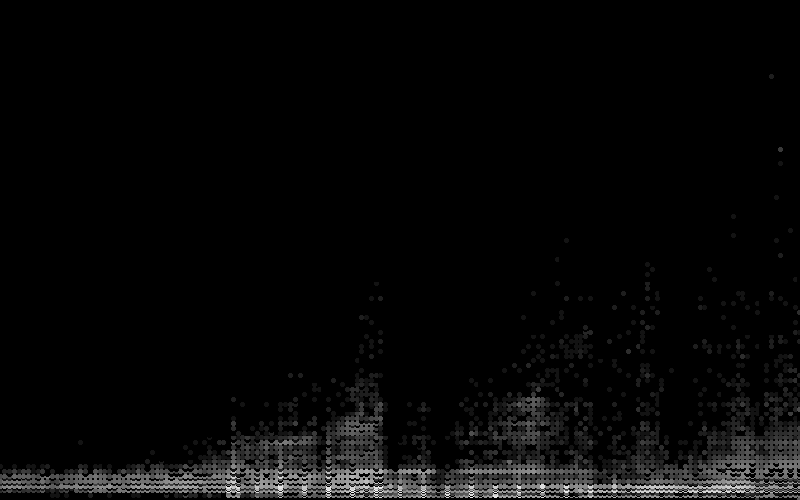

In [13]:
cvs = ds.Canvas(800, 500, x_range = (ny['yearbuilt'].min(), ny['yearbuilt'].max()), 
                                y_range = (ny['numfloors'].min(), ny['numfloors'].max()))
agg = cvs.points(ny, 'yearbuilt', 'numfloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

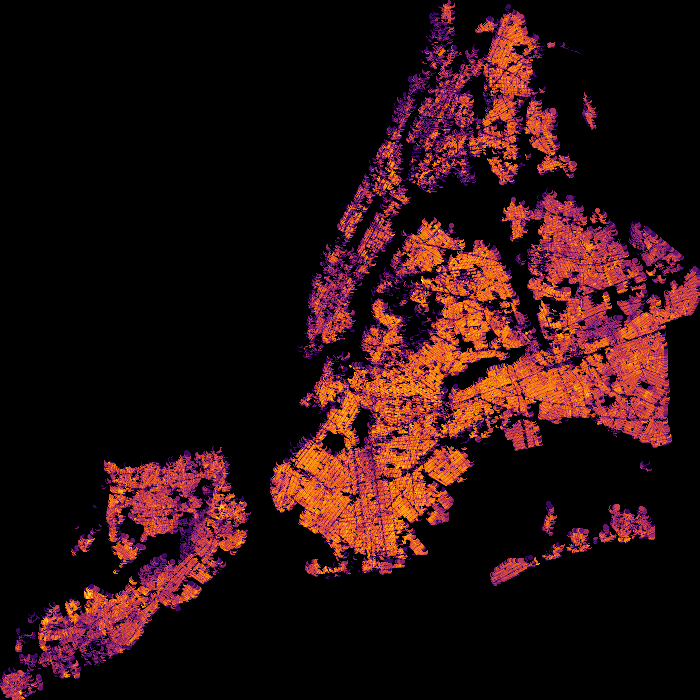

In [14]:
NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

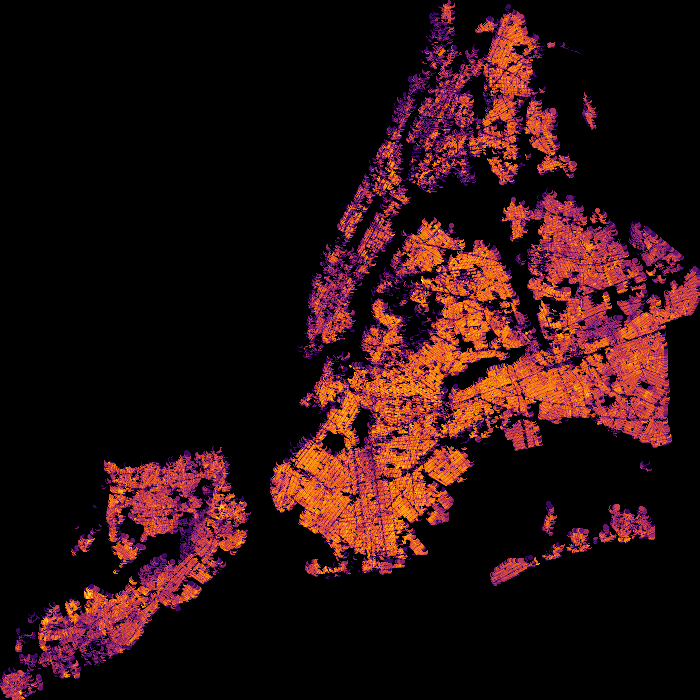

In [15]:
NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

### Approach 1

After reading the article on choropleth, I thought I would create a map of NYC using the assessed total and a map of NYC with the assessed land value. I would overlay those two maps and cross my fingers, hope the overlaying of the two maps would mimic the choropleth


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning:

invalid value encountered in less



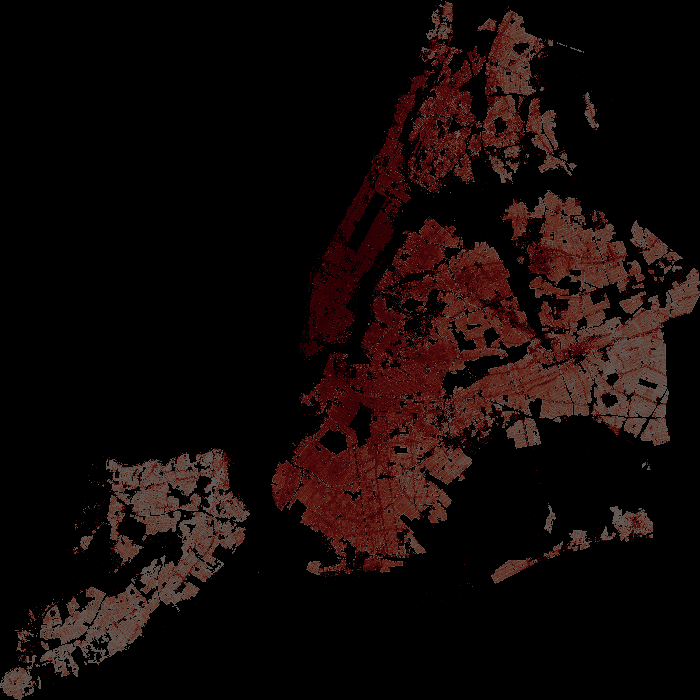

In [16]:
from matplotlib import cm as mcm 

cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord', ds.sum('assesstot'))
img1 = tf.shade(agg, cmap = mcm.Reds, how='eq_hist', alpha=100)

export(img1, 'Assessment Total Value')

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning:

invalid value encountered in less



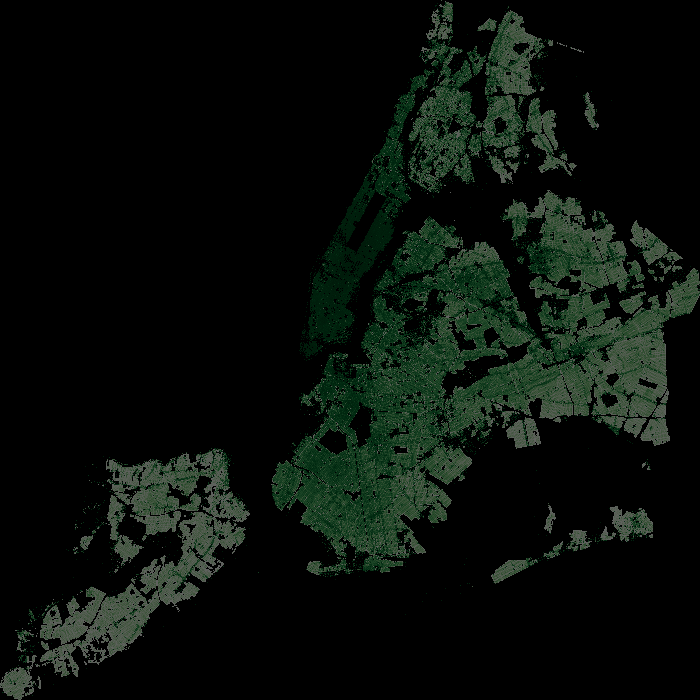

In [17]:
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord', ds.sum('assessland'))
img2 = tf.shade(agg, cmap = mcm.Greens, how='eq_hist', alpha=100)

export(img2, 'Assessment Land Value')

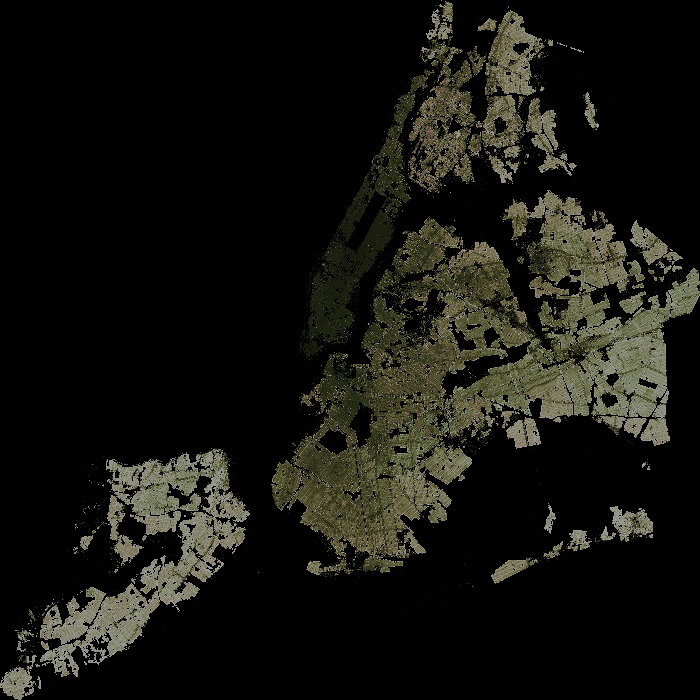

In [18]:
img3 = tf.stack(img1,img2,how='over')

export(img3, 'Combined')

The above map is the result of my naive attempt to overlap two maps. I just ended up with this muddy map with no green and no red highlights. Thus, something was not working. Also, I realized instead of the overall assessed total value, I needed to calculate the actual building value.

### Approach 2

Realizing the muddy image above wasn't the correct approach, I decided I needed to define each coordinate 1 of 9 values, following the 3x3 color matrix from the Joshua Stevens blog about choropleth. Also, the more I considered the building value, I decided to subtract the land value from the total value to ensure I truly was using the building value.

In [19]:
# Calculate the actual building value using the overall value less the land value
ny['assessbldg'] = ny['assesstot'] - ny['assessland']

ny.head()

borough  block  lot     cd  ct2010  cb2010  schooldist  council  zipcode  \
17       BK   8366  222  318.0  696.02  2002.0        22.0     46.0  11234.0   
58       BK   2571   28  301.0  561.00  1005.0        14.0     33.0  11222.0   
79       BK   3197    8  304.0  429.00  1002.0        32.0     34.0  11237.0   
110      QN     52    7  402.0    7.00  1000.0        30.0     26.0  11101.0   
126      BK   6714   55  314.0  534.00  3000.0        21.0     44.0  11230.0   

    firecomp  ...  firm07_flag  pfirm15_flag  version  dcpedited   latitude  \
17      E323  ...          NaN           NaN     20v5        NaN  40.621954   
58      L106  ...          NaN           NaN     20v5        NaN  40.727214   
79      E218  ...          NaN           NaN     20v5        NaN  40.701450   
110     L115  ...          NaN           NaN     20v5        NaN  40.747702   
126     L156  ...          NaN           NaN     20v5        NaN  40.622939   

     longitude notes floor_bins decade assessbldg  
17  -73.912938   NaN        1-9   2010        0.0  
58  -73.957625   NaN        1-9   2010    15780.0  
79  -73.926539   NaN        1-9   1930   222300.0  
110 -73.948207   NaN        1-9   1950   967500.0  
126 -73.963523   NaN        1-9   1930   200250.0  

[5 rows x 93 columns]

#### Determine color on matrix

Knowing I needed to determine the specific color for each coordinate pair, I separated the land and building values into three bins by calculating the third and two thirds breakpoints for each column. Once, I had the breakpoints needed, I then labeled each coordinate with the proper land and building value. With each value determined, I concatenated the values to finalize the category A1-C3 to define the proper color.

In [20]:
# Define the labels to be used in defining the color of the 3x3 matrix
labels_land = ['A', 'B', 'C'] # Green tone C1 is valueable land, not valuable building
labels_bldg = ['1', '2', '3'] # Pink tone A3 is valuaeable building, not valuable land

# Define percentile for dividing by 3 (33.33)
pct = 100 / 3

# Create the breakpoints for the two columns, land and building
bp_land = np.percentile(ny['assessland'], [pct, 100 - pct], axis=0)

bp_bldg = np.percentile(ny['assessbldg'], [pct, 100 - pct], axis=0)

# Bin the land assessments
ny['land_label'] = pd.cut(ny['assessland'], [0, bp_land[0], bp_land[1], np.inf], right=False, labels=labels_land)

# Bin the building assessments
ny['bldg_label'] = pd.cut(ny['assessbldg'], [0, bp_bldg[0], bp_bldg[1], np.inf], right=False, labels=labels_bldg)

# Concatenate the land and building labels
ny['color'] = ny['land_label'].astype(str) + ny['bldg_label'].astype(str)
ny['color'] = pd.Categorical(ny['color'])
ny.head()

borough  block  lot     cd  ct2010  cb2010  schooldist  council  zipcode  \
17       BK   8366  222  318.0  696.02  2002.0        22.0     46.0  11234.0   
58       BK   2571   28  301.0  561.00  1005.0        14.0     33.0  11222.0   
79       BK   3197    8  304.0  429.00  1002.0        32.0     34.0  11237.0   
110      QN     52    7  402.0    7.00  1000.0        30.0     26.0  11101.0   
126      BK   6714   55  314.0  534.00  3000.0        21.0     44.0  11230.0   

    firecomp  ...  dcpedited   latitude  longitude  notes  floor_bins decade  \
17      E323  ...        NaN  40.621954 -73.912938    NaN         1-9   2010   
58      L106  ...        NaN  40.727214 -73.957625    NaN         1-9   2010   
79      E218  ...        NaN  40.701450 -73.926539    NaN         1-9   1930   
110     L115  ...        NaN  40.747702 -73.948207    NaN         1-9   1950   
126     L156  ...        NaN  40.622939 -73.963523    NaN         1-9   1930   

    assessbldg land_label bldg_label color  
17         0.0          A          1    A1  
58     15780.0          C          1    C1  
79    222300.0          C          3    C3  
110   967500.0          A          3    A3  
126   200250.0          C          3    C3  

[5 rows x 96 columns]

Define the color key as suggested at https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/

In [21]:
color_key = {'C3':'#3b4994', 
             'B3':'#8c62aa',
             'A3':'#be64ac', 
             'C2':'#5698b9', 
             'B2':'#a5add3',
             'A2':'#dfb0d6',
             'C1':'#5ac8c8', 
             'B1':'#ace4e4',
             'A1':'#e8e8e8'}

#### Render the map of NYC

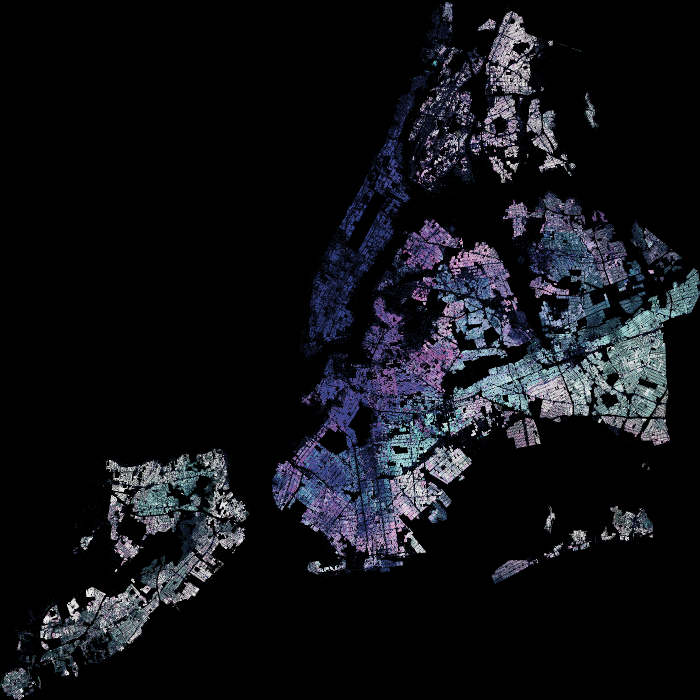

In [22]:
NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord', ds.count_cat('color'))
imgChoro = tf.shade(agg, color_key=color_key)
export(imgChoro, 'Final Answer')

In [23]:
import bokeh.io
from bokeh.io import show
from datashader.bokeh_ext import create_categorical_legend

bokeh.io.reset_output()
bokeh.io.output_notebook()

show(create_categorical_legend(color_key))

Loading BokehJS ...

### Explanation
Using the above colored map with the choropleth colors defined above, here's the results:

- Green/mint tone C1 is valuable land, but without valuable building -  C1: Underbuilt
- Pink tone A3 is valuable building, but not on valuable land - A3: Overbuilt
- Properly correlated: A1, B2, C3

I'm not sure on my NYC geography, but it would seem Brooklyn and Queens just east of Manhattan are overbuilt. While Brooklyn and Queens much farther east from Manhattan are underbuilt.